In [1]:
# Importation des bibliothèques pour l'analyse de données
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

# Importation des bibliothèques pour la visualisation de données
import matplotlib.pyplot as plt

# Importation des bibliothèques pour le contrat de maintenance
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

In [2]:
df_maintenance = pd.read_csv("df_analyse.csv")

In [3]:
df_maintenance

,order_purchase_timestamp,customer_unique_id,average_installments,average_review_score,recency,frequency,monetary,most_frequent_payment_type,most_frequent_category
0,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1.0,4.0,699,1,39.09,boleto,sports_leisure
1,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1.0,3.0,699,1,53.73,boleto,sports_leisure
2,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,6.0,1.0,699,1,133.46,credit_card,furniture_decor
3,2016-10-03 22:31:31,87776adb449c551e74c13fc34f036105,4.0,5.0,699,1,40.95,credit_card,fashion_shoes
4,2016-10-03 22:44:10,7390ed59fa1febbfda31a80b4318c8cb,2.0,5.0,699,1,154.57,credit_card,toys
...,...,...,...,...,...,...,...,...,...
92749,2018-08-29 12:25:59,7a22d14aa3c3599238509ddca4b93b01,7.0,1.0,4,1,73.10,credit_card,toys
92750,2018-08-29 14:18:23,5c58de6fb80e93396e2f35642666b693,8.0,5.0,4,1,510.96,credit_card,kitchen_dining_laundry_garden_furniture
92751,2018-08-29 14:18:28,7febafa06d9d8f232a900a2937f04338,1.0,5.0,4,1,61.29,voucher,health_beauty
92752,2018-08-29 14:52:00,b701bebbdf478f5500348f03aff62121,1.0,3.0,4,1,33.23,credit_card,party_supplies


In [4]:
df_maintenance['order_purchase_timestamp'] = pd.to_datetime(df_maintenance['order_purchase_timestamp'])
df_maintenance = df_maintenance.drop(['customer_unique_id','most_frequent_payment_type', 'most_frequent_category', 'average_installments'], axis=1)

In [5]:
min_order_date = df_maintenance["order_purchase_timestamp"].min()

In [6]:
print("Date de la première commande:", min_order_date)
print("Date de la dernière commande:", df_maintenance["order_purchase_timestamp"].max())

Date de la première commande: 2016-10-03 16:56:50
Date de la dernière commande: 2018-08-29 15:00:37


In [7]:
# Filtrage de df_analyse avec les features nécessaires

selected_variables = ["recency", "frequency", "monetary", "average_review_score"]
df_maintenance_selected = df_maintenance[selected_variables]

In [8]:
# Filtrage des données pour la période de base

base_period_mask = (
    (df_maintenance['order_purchase_timestamp'] >= '2017-01-01') &
    (df_maintenance['order_purchase_timestamp'] <= '2017-12-31')
)

df_base_period = df_maintenance.loc[base_period_mask]

In [9]:
def prepare_data_for_model(df):
    """Prépare les données pour le modèle."""
    df_copy = df.copy()
    
    df_copy['recency'] = np.log1p(df_copy['recency'])
    df_copy['frequency'] = np.log1p(df_copy['frequency'])
    df_copy['monetary'] = np.log1p(df_copy['monetary'])
    
    features_to_scale = ['recency', 'frequency', 'monetary', 'average_review_score']
    scaler = MinMaxScaler()
    
    df_scaled_array = scaler.fit_transform(df_copy[features_to_scale])
    df_scaled = pd.DataFrame(df_scaled_array, columns=features_to_scale)
    return df_scaled, scaler

In [10]:
def prepare_data_for_model_bis(df, scaler_0):
    """Prépare les nouvelles données pour le modèle en utilisant un scaler existant."""
    df_copy = df.copy()
    
    df_copy['recency'] = np.log1p(df_copy['recency'])
    df_copy['frequency'] = np.log1p(df_copy['frequency'])
    df_copy['monetary'] = np.log1p(df_copy['monetary'])
    
    # Utilisation du scaler existant pour transformer les nouvelles données
    df_scaled_array = scaler_0.transform(df_copy[features_to_scale])
    df_scaled = pd.DataFrame(df_scaled_array, columns=features_to_scale)
    return df_scaled

In [11]:
# Préparer les données de la période de base pour le modèle

prepared_base_data, scaler0 = prepare_data_for_model(df_base_period[selected_variables])

In [12]:
# Entraîner le modèle de clustering initial (M0) sur la période de base

model_0 = KMeans(n_clusters=4,n_init=10, random_state=42)
model_0.fit(prepared_base_data)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [13]:
# Liste de la nouvelle période

start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-08-29')

new_periods = []

current_date = start_date
while current_date <= end_date:
    period_start = current_date.strftime('%Y-%m-%d')
    period_end = (current_date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    new_periods.append((period_start, period_end))
    current_date += pd.offsets.MonthBegin(1)

for period in new_periods:
    print(period)

('2018-01-01', '2018-01-31')
('2018-02-01', '2018-02-28')
('2018-03-01', '2018-03-31')
('2018-04-01', '2018-04-30')
('2018-05-01', '2018-05-31')
('2018-06-01', '2018-06-30')
('2018-07-01', '2018-07-31')
('2018-08-01', '2018-08-31')


In [14]:
features_to_scale = ['recency', 'frequency', 'monetary', 'average_review_score']

In [15]:
# Analyse de chaque période et calcule des ARI Score

ari_scores = []
for start_date, end_date in new_periods:
    new_period_mask = (
        (df_maintenance['order_purchase_timestamp'] >= start_date) &
        (df_maintenance['order_purchase_timestamp'] <= end_date)
    )
    new_period_data = df_maintenance.loc[new_period_mask]

    prepared_new_data = prepare_data_for_model_bis(new_period_data[selected_variables], scaler0)
    
    predicted_clusters = model_0.predict(prepared_new_data)
    
    model_1 = KMeans(n_clusters=4, n_init=10, random_state=42)
    model_1.fit(prepared_new_data)
    
    ari_score = adjusted_rand_score(predicted_clusters, model_1.labels_)
    ari_scores.append(ari_score)
    print(f"ARI score for the period {start_date} to {end_date}: {ari_score}")

ARI score for the period 2018-01-01 to 2018-01-31: 1.0
ARI score for the period 2018-02-01 to 2018-02-28: 1.0
ARI score for the period 2018-03-01 to 2018-03-31: 1.0
ARI score for the period 2018-04-01 to 2018-04-30: 0.9891284190055514
ARI score for the period 2018-05-01 to 2018-05-31: 1.0
ARI score for the period 2018-06-01 to 2018-06-30: 1.0
ARI score for the period 2018-07-01 to 2018-07-31: 1.0
ARI score for the period 2018-08-01 to 2018-08-31: 0.5361325599104396


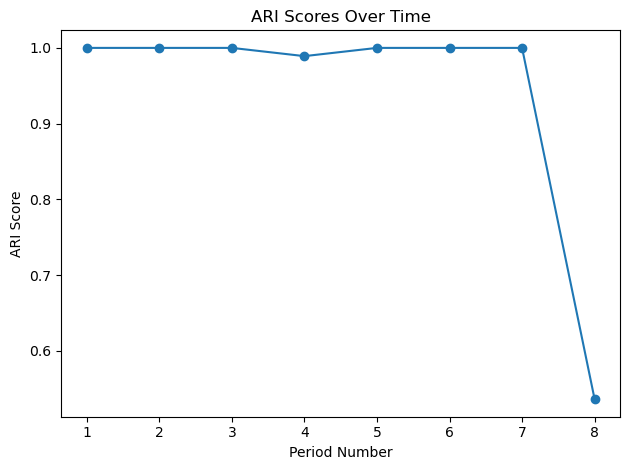

In [16]:
# Visualisation des score ARI sur la période (en mensuel)

plt.plot(range(1, len(ari_scores) + 1), ari_scores, marker='o')
plt.title('ARI Scores Over Time')
plt.xlabel('Period Number')
plt.ylabel('ARI Score')
plt.xticks(ticks=range(1, len(ari_scores) + 1))
plt.tight_layout()
plt.show()

**Conclusion :**  
Les scores ARI élevés sur plusieurs périodes suggèrent que le modèle de segmentation actuel performait bien, avec une excellente correspondance entre les clusters prédits et les véritables structures de données.  

Toutefois, la chute abrupte dans le score ARI pour la dernière période (au bout de 8 mois) indique une divergence entre les groupes prédits par le modèle et les groupes réels.  

**Proposition de maintenance:**  

Évaluation Trimestrielle : Analyse des scores ARI tous les trois mois pour détecter tout changement significatif dans la qualité du clustering.  

Réévaluation Semestrielle : Réévaluation complète des modèles au bout de 6 mois, y compris la réentrainement potentiel avec de nouvelles données pour ajuster aux évolutions du marché.  

Ajustements Annuels : Revue annuelle pour ajuster le modèle.